<a href="https://colab.research.google.com/github/Le-Zheng/analytics-zoo/blob/colab/docs/docs/colab-tutorials/image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Environment Preparation

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
!java -version

openjdk version "1.8.0_275"
OpenJDK Runtime Environment (build 1.8.0_275-8u275-b01-0ubuntu1~18.04-b01)
OpenJDK 64-Bit Server VM (build 25.275-b01, mixed mode)


In [ ]:
# Install latest release version of analytics-zoo 
# Installing analytics-zoo from pip will automatically install pyspark, bigdl, and their dependencies.
!pip install analytics-zoo

In [ ]:
# Install python dependencies
!pip install tensorflow==1.15.0

### **image_segmentation example**

**Data preparation**

You should manually download the dataset from kaggle carvana-image-masking-challenge, and save it to /tmp/carvana/. We will need three files, train.zip, train_masks.zip and train_masks.csv.zip

You can follow [easiest way to download kaggle data in Google Colab](https://www.kaggle.com/general/74235) to download and use kaggle data within Google Colab.

In [ ]:
# config kaggle within Colab
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lezhengjoy","key":"518a0ca5726ab37c9adf09ada99bd314"}'}

In [ ]:
# download the dataset from kaggle carvana-image-masking-challenge
!kaggle competitions download -c carvana-image-masking-challenge -p /tmp/carvana

 98% 15.0M/15.3M [00:00<00:00, 155MB/s]
100% 15.3M/15.3M [00:00<00:00, 140MB/s]
 79% 23.0M/29.1M [00:00<00:00, 70.8MB/s]
100% 29.1M/29.1M [00:00<00:00, 83.8MB/s]
  0% 0.00/202k [00:00<?, ?B/s]
100% 202k/202k [00:00<00:00, 164MB/s]
 99% 793M/804M [00:08<00:00, 116MB/s]
100% 804M/804M [00:08<00:00, 95.2MB/s]
  0% 0.00/107k [00:00<?, ?B/s]
100% 107k/107k [00:00<00:00, 112MB/s]
 97% 392M/405M [00:02<00:00, 178MB/s]
100% 405M/405M [00:02<00:00, 190MB/s]
  0% 0.00/81.2k [00:00<?, ?B/s]
100% 81.2k/81.2k [00:00<00:00, 68.2MB/s]
100% 7.74G/7.76G [02:06<00:00, 126MB/s]
100% 7.76G/7.76G [02:06<00:00, 65.6MB/s]
100% 15.4G/15.4G [04:36<00:00, 43.1MB/s]
100% 15.4G/15.4G [04:36<00:00, 60.1MB/s]


**Run image segmentation example**

Prepending /usr/local/lib/python3.6/dist-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
Adding /usr/local/lib/python3.6/dist-packages/zoo/share/lib/analytics-zoo-bigdl_0.12.1-spark_2.4.3-0.9.0-jar-with-dependencies.jar to BIGDL_JARS
Prepending /usr/local/lib/python3.6/dist-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path

Initializing orca context
Current pyspark location is : /usr/local/lib/python3.6/dist-packages/pyspark/__init__.py
Start to getOrCreate SparkContext
pyspark_submit_args is:  --driver-class-path /usr/local/lib/python3.6/dist-packages/zoo/share/lib/analytics-zoo-bigdl_0.12.1-spark_2.4.3-0.9.0-jar-with-dependencies.jar:/usr/local/lib/python3.6/dist-packages/bigdl/share/lib/bigdl-0.12.1-jar-with-dependencies.jar pyspark-shell 
Successfully got a SparkContext
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model"
_______

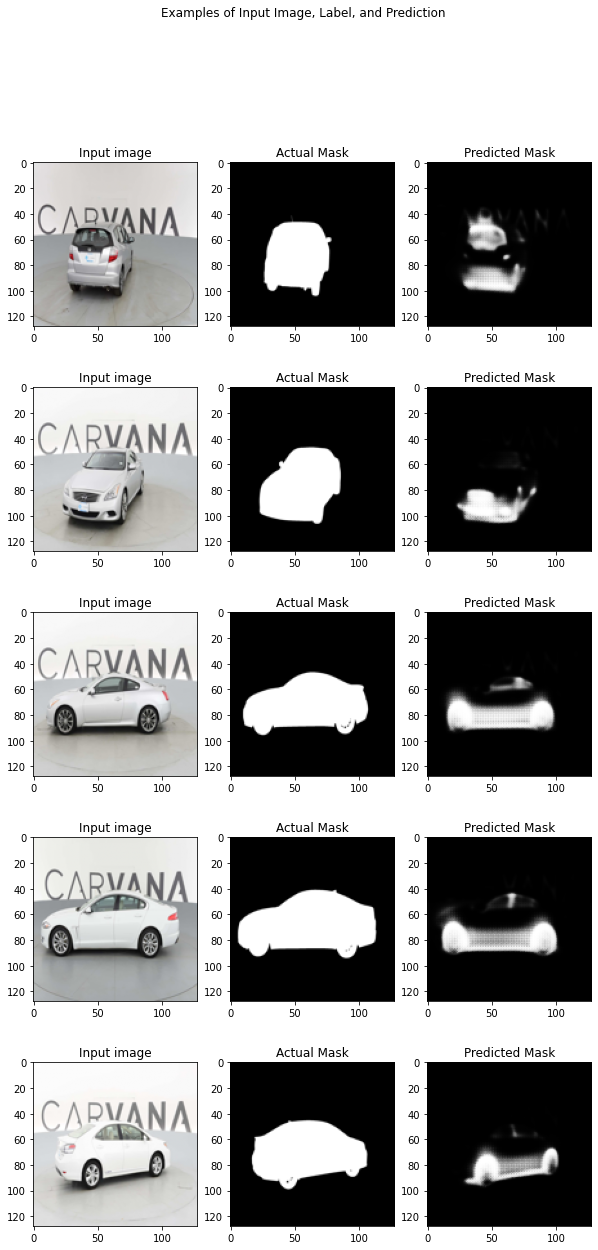

Stopping orca context
Try to unpersist an uncached rdd
Try to unpersist an uncached rdd
Try to unpersist an uncached rdd
Try to unpersist an uncached rdd


In [ ]:
#
# Copyright 2018 Analytics Zoo Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#
import argparse
import os
import zipfile
import pandas as pd
from PIL import Image

import tensorflow as tf
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models
from tensorflow.python.keras import backend as K
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

from zoo.orca import init_orca_context, stop_orca_context
from zoo.orca.data import XShards
from zoo.orca.learn.tf.estimator import Estimator


def load_data_from_zip(file_path, file):
    with zipfile.ZipFile(os.path.join(file_path, file), "r") as zip_ref:
        unzipped_file = zip_ref.namelist()[0]
        zip_ref.extractall(file_path)


def load_data(file_path):
    load_data_from_zip(file_path, 'train.zip')
    load_data_from_zip(file_path, 'train_masks.zip')
    load_data_from_zip(file_path, 'train_masks.csv.zip')


def main(cluster_mode, max_epoch, file_path, batch_size, platform, non_interactive):
    import matplotlib
    if not non_interactive and platform == "mac":
        matplotlib.use('qt5agg')

    if cluster_mode == "local":
        init_orca_context(cluster_mode="local", cores=4, memory="3g")
    elif cluster_mode == "yarn":
        init_orca_context(cluster_mode="yarn-client", num_nodes=2, cores=2, driver_memory="3g")

    load_data(file_path)
    img_dir = os.path.join(file_path, "train")
    label_dir = os.path.join(file_path, "train_masks")

    # Here we only take the first 1000 files for simplicity
    df_train = pd.read_csv(os.path.join(file_path, 'train_masks.csv'))
    ids_train = df_train['img'].map(lambda s: s.split('.')[0])
    ids_train = ids_train[:1000]

    x_train_filenames = []
    y_train_filenames = []
    for img_id in ids_train:
        x_train_filenames.append(os.path.join(img_dir, "{}.jpg".format(img_id)))
        y_train_filenames.append(os.path.join(label_dir, "{}_mask.gif".format(img_id)))

    x_train_filenames, x_val_filenames, y_train_filenames, y_val_filenames = \
        train_test_split(x_train_filenames, y_train_filenames, test_size=0.2, random_state=42)

    def load_and_process_image(path):
        array = mpimg.imread(path)
        result = np.array(Image.fromarray(array).resize(size=(128, 128)))
        result = result.astype(float)
        result /= 255.0
        return result

    def load_and_process_image_label(path):
        array = mpimg.imread(path)
        result = np.array(Image.fromarray(array).resize(size=(128, 128)))
        result = np.expand_dims(result[:, :, 1], axis=-1)
        result = result.astype(float)
        result /= 255.0
        return result

    train_images = np.stack([load_and_process_image(filepath) for filepath in x_train_filenames])
    train_label_images = np.stack([load_and_process_image_label(filepath)
                                   for filepath in y_train_filenames])
    val_images = np.stack([load_and_process_image(filepath) for filepath in x_val_filenames])
    val_label_images = np.stack([load_and_process_image_label(filepath)
                                 for filepath in y_val_filenames])
    train_shards = XShards.partition({"x": train_images, "y": train_label_images})
    val_shards = XShards.partition({"x": val_images, "y": val_label_images})

    # Build the U-Net model
    def conv_block(input_tensor, num_filters):
        encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
        encoder = layers.Activation('relu')(encoder)
        encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
        encoder = layers.Activation('relu')(encoder)
        return encoder

    def encoder_block(input_tensor, num_filters):
        encoder = conv_block(input_tensor, num_filters)
        encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)

        return encoder_pool, encoder

    def decoder_block(input_tensor, concat_tensor, num_filters):
        decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(
            input_tensor)
        decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
        decoder = layers.Activation('relu')(decoder)
        decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
        decoder = layers.Activation('relu')(decoder)
        decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
        decoder = layers.Activation('relu')(decoder)
        return decoder

    inputs = layers.Input(shape=(128, 128, 3))      # 128
    encoder0_pool, encoder0 = encoder_block(inputs, 16)     # 64
    encoder1_pool, encoder1 = encoder_block(encoder0_pool, 32)      # 32
    encoder2_pool, encoder2 = encoder_block(encoder1_pool, 64)      # 16
    encoder3_pool, encoder3 = encoder_block(encoder2_pool, 128)     # 8
    center = conv_block(encoder3_pool, 256)     # center
    decoder3 = decoder_block(center, encoder3, 128)     # 16
    decoder2 = decoder_block(decoder3, encoder2, 64)    # 32
    decoder1 = decoder_block(decoder2, encoder1, 32)    # 64
    decoder0 = decoder_block(decoder1, encoder0, 16)    # 128
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)

    net = models.Model(inputs=[inputs], outputs=[outputs])

    # Define custom metrics
    def dice_coeff(y_true, y_pred):
        smooth = 1.
        # Flatten
        y_true_f = tf.reshape(y_true, [-1])
        y_pred_f = tf.reshape(y_pred, [-1])
        intersection = tf.reduce_sum(y_true_f * y_pred_f)
        score = (2. * intersection + smooth) / \
                (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
        return score

    # Define custom loss function
    def dice_loss(y_true, y_pred):
        loss = 1 - dice_coeff(y_true, y_pred)
        return loss

    def bce_dice_loss(y_true, y_pred):
        loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
        return loss

    # compile model
    net.compile(optimizer=tf.keras.optimizers.Adam(2e-3), loss=bce_dice_loss)
    print(net.summary())

    # create an estimator from keras model
    est = Estimator.from_keras(keras_model=net)
    # fit with estimator
    est.fit(data=train_shards,
            batch_size=batch_size,
            epochs=max_epoch)
    # evaluate with estimator
    result = est.evaluate(val_shards)
    print(result)
    # predict with estimator
    val_shards.cache()
    val_image_shards = val_shards.transform_shard(lambda val_dict: {"x": val_dict["x"]})
    pred_shards = est.predict(data=val_image_shards, batch_size=batch_size)
    pred = pred_shards.collect()[0]["prediction"]
    val_image_label = val_shards.collect()[0]
    val_image = val_image_label["x"]
    val_label = val_image_label["y"]
    if not non_interactive:
        # visualize 5 predicted results
        plt.figure(figsize=(10, 20))
        for i in range(5):
            img = val_image[i]
            label = val_label[i]
            predicted_label = pred[i]

            plt.subplot(5, 3, 3 * i + 1)
            plt.imshow(img)
            plt.title("Input image")

            plt.subplot(5, 3, 3 * i + 2)
            plt.imshow(label[:, :, 0], cmap='gray')
            plt.title("Actual Mask")
            plt.subplot(5, 3, 3 * i + 3)
            plt.imshow(predicted_label, cmap='gray')
            plt.title("Predicted Mask")
        plt.suptitle("Examples of Input Image, Label, and Prediction")

        plt.show()

    stop_orca_context()


if __name__ == '__main__':
    cluster_mode = "local"
    epochs = 1
    file_path = "/tmp/carvana/"
    batch_size = 8
    platform = "linux"
    non_interactive = False
    
    main(cluster_mode, epochs, file_path, batch_size, platform,
         non_interactive)